Для выполнения этого задания вам понадобятся данные о кредитных историях клиентов одного из банков. Поля в предоставляемых данных имеют следующий смысл:

LIMIT_BAL: размер кредитного лимита (в том числе и на семью клиента)

SEX: пол клиента (1 = мужской, 2 = женский)

EDUCATION: образование (0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5 = прочее; 6 = нет данных).

MARRIAGE: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных).

AGE: возраст в годах

PAY_0 - PAY_6 : История прошлых платежей по кредиту. PAY_6 - платеж в апреле, ... PAY_0 - платеж в сентябре. Платеж = (0 = исправный платеж, 1 = задержка в один месяц, 2 = задержка в 2 месяца, …)

BILL_AMT1 - BILL_AMT6: задолженность, BILL_AMT6 - на апрель, BILL_AMT1 - на сентябрь

PAY_AMT1 - PAY_AMT6: сумма уплаченная в PAY_AMT6 - апреле, …, PAY_AMT1 - сентябре

default - индикатор невозврата денежных средств

In [1]:

from math import sqrt
from typing import Sequence

import numpy
import pandas
from matplotlib import pyplot
from scipy import stats
from statsmodels.stats.multitest import multipletests

%matplotlib notebook
pandas.set_option('display.max_columns', 500)

In [2]:
dataset = pandas.read_csv('credit_card_default_analysis.csv')
dataset.head()

IOError: File credit_card_default_analysis.csv does not exist

In [ ]:
pandas.DataFrame(dataset['default'].value_counts())

## Размер кредитного лимита (LIMIT_BAL)
В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверьте гипотезы:

о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки

о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних.

Значимы ли полученные результаты с практической точки зрения?

Давайте изобразим исследуемую величину:

In [4]:
non_default_limit_bal = dataset[dataset['default'] == 0]['LIMIT_BAL']
default_limit_bal = dataset[dataset['default'] == 1]['LIMIT_BAL']

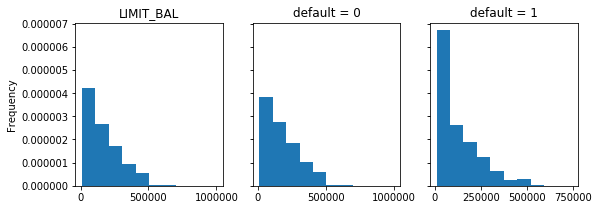

In [5]:
_, axes = pyplot.subplots(nrows=1, ncols=3, sharey='row', figsize=(9, 3))

dataset['LIMIT_BAL'].plot.hist(ax=axes[0], normed=True).set_title('LIMIT_BAL')
non_default_limit_bal.plot.hist(ax=axes[1], normed=True).set_title('default = 0')
default_limit_bal.plot.hist(ax=axes[2], normed=True).set_title('default = 1')
pyplot.show()

Пока вижу, что у группы default = 1 есть скос распределения влево.

Перед применением критериев хотелось бы убедиться, что общие формы этих распределений не сильно отличаются. Изобразим распределение логарифмов исследуемой величины в надежде привести ее к более-менее нормальной форме:

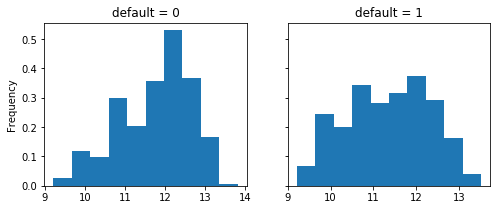

In [7]:
_, axes = pyplot.subplots(nrows=1, ncols=2, sharey='row', figsize=(8, 3))

non_default_limit_bal.apply(numpy.log).plot.hist(ax=axes[0], normed=True).set_title('default = 0')
default_limit_bal.apply(numpy.log).plot.hist(ax=axes[1], normed=True).set_title('default = 1')
pyplot.show()

Не так уж и плохо.

Давайте проверим, что у этих двух групп медианы лимита значимо отличаются. Проверять будем бутстрап-критерием равенство математических ожиданий медиан в группах против двухсторонней альтернативы. Соответственно, нулевая гипотеза: математические ожидания медиан равны.

In [8]:
def sample(data, n_samples):
    return data[numpy.random.randint(0, len(data), (n_samples, len(data)))]

def statistics_intervals(statistics, alpha):
    return numpy.percentile(statistics, [100. * alpha / 2., 100. * (1. - alpha / 2.)])

numpy.random.seed(42)
n_samples = 100
non_default_limit_bal_medians = numpy.median(sample(non_default_limit_bal.values, n_samples), axis=1)
default_limit_bal_medians = numpy.median(sample(default_limit_bal.values, n_samples), axis=1)
statistics_intervals(default_limit_bal_medians - non_default_limit_bal_medians, 0.05)

array([-70000., -60000.])

Действительно: кредитный лимит у "невозвращенцев" меньше кредитного лимита "возвращенцев". 95%-ый доверительный интервал для разности лимитов первых и вторых – (-70000, -60000), ноль в интервале не содержится.

Давайте теперь проверим равенство распределений. И здесь нам поможет критерий Манна-Уитни для двухвыброчной задачи с независимыми выборками. Нулевая гипотеза: распределения равны против общей альтернативы – распределения равны, но с ненулевым сдвигом.

In [9]:
stats.mannwhitneyu(default_limit_bal.values, non_default_limit_bal.values, alternative='two-sided')

MannwhitneyuResult(statistic=59257217.5, pvalue=1.2255485818223303e-189)


Нулевая гипотеза уверенно отвергается, средние двух выборок отличаются. Вероятно, этот признак полезен.

## Пол (SEX)
Проверьте гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается. Хорошо, если вы предоставите несколько различных решений этой задачи (с помощью доверительного интервала и подходящего статистического критерия).

Так, давайте посмотрим на матрицу сопряженности признака SEX и искомой метки default.

In [10]:
sex_default_crosstab = pandas.crosstab(dataset['SEX'], dataset['default'])
sex_default_crosstab

default,0,1
SEX,,
1,9015,2873
2,14349,3763


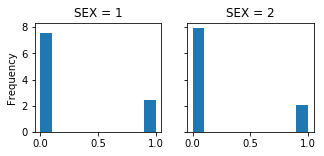

In [11]:
#  Ну и на графики заодно.

_, axes = pyplot.subplots(nrows=1, ncols=2, sharey='row', figsize=(5, 2))

dataset[dataset['SEX'] == 1]['default'].plot.hist(ax=axes[0], normed=True).set_title('SEX = 1')
dataset[dataset['SEX'] == 2]['default'].plot.hist(ax=axes[1], normed=True).set_title('SEX = 2')
pyplot.show()

Сходу не видно, отличаются ли доли для default в обоих группах по полу. Давайте применим критерий для сравнения долей. Нулевая гипотеза: доли "невозвращенцев" в обоих группах не различаются – против общей альтернативы.

In [28]:
def proportions_diff_z_stat_ind(s1, n1, s2, n2) :
    p1 = float(s1) / float(n1)
    p2 = float(s2) / float(n2) 
    P = (float(s1) + float(s2)) / (float(n1) + float(n2))
    return (p1 - p2) / sqrt(P * (1. - P) * (1. / n1 + 1. / n2))


def proportions_diff_z_test(z_stat, alternative='two-sided') :
    if alternative == 'two-sided':
        return 2. * (1. - stats.norm.cdf(abs(z_stat)))
    
    if alternative == 'less':
        return stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1. - stats.norm.cdf(z_stat)


'P-value: %s' % proportions_diff_z_test(proportions_diff_z_stat_ind(
    sex_default_crosstab[1][1],  # default = 1, SEX = 1
    sex_default_crosstab[0][1] + sex_default_crosstab[1][1],  # SEX = 1
    sex_default_crosstab[1][2],  # default = 1, SEX = 2
    sex_default_crosstab[0][2] + sex_default_crosstab[1][2],  # SEX = 2
))

'P-value: 4.472866521609831e-12'

Нулевая гипотеза отвергается, доли значимо различаются. Давайте посмотрим на доверительный интервал для разности долей:

In [32]:
def proportions_diff_confint_ind(s1, n1,  s2, n2, alpha=0.05):    
    z = stats.norm.ppf(1. - alpha / 2.)
    
    p1 = float(s1) / float(n1)
    p2 = float(s2) / float(n2)
    
    d = z * sqrt(p1 * (1. - p1) / float(n1) + p2 * ((1. - p2) / float(n2)))
    left_boundary = (p1 - p2) - d 
    right_boundary = (p1 - p2) + d
    
    return (left_boundary, right_boundary)


proportions_diff_confint_ind(
    sex_default_crosstab[1][1],  # default = 1, SEX = 1
    sex_default_crosstab[0][1] + sex_default_crosstab[1][1],  # SEX = 1
    sex_default_crosstab[1][2],  # default = 1, SEX = 2
    sex_default_crosstab[0][2] + sex_default_crosstab[1][2],  # SEX = 2
)

(0.024207372179792706, 0.0436115585708172)

По всей видимости, доля неплательщиков среди представителей пола 1 значимо выше, доверительный интервал: (0.0242, 0.0436). Хороший признак.

## Образование (EDUCATION)
Проверьте гипотезу о том, что образование не влияет на то, вернет ли человек долг.

Предложите способ наглядного представления разницы в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг. Например, составьте таблицу сопряженности "образование" на "возврат долга", где значением ячейки была бы разность между наблюдаемым и ожидаемым количеством человек.

Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости?

Наличие какого образования является наилучшим индикатором того, что человек отдаст долг? Наоборот, не отдаст долг?

Ну давайте снова посмотрим на таблицу сопряженности (пока просто без ожидаемых значений):

In [33]:
education_crosstab = pandas.crosstab(dataset['EDUCATION'], dataset['default'])
education_crosstab

default,0,1
EDUCATION,,
0,14,0
1,8549,2036
2,10700,3330
3,3680,1237
4,116,7
5,262,18
6,43,8


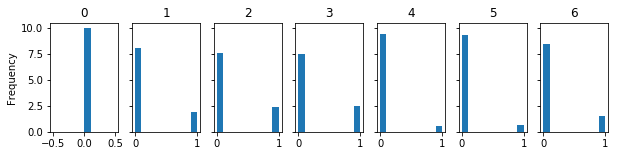

In [34]:
_, axes = pyplot.subplots(nrows=1, ncols=7, sharey='row', figsize=(10, 2))

for education in range(7):
    dataset[dataset['EDUCATION'] == education]['default'].plot.hist(ax=axes[education], normed=True).set_title(education)
pyplot.show()

Похоже, что образование влияет на возврат долга. Давайте проверим это формально. Будем использовать критерий хи-квадрат для категориальных признаков. Нулевая гипотеза: коррелляция между этими двумя признаками отсутствует – против общей альтернативы.

In [35]:
chi2, p, dof, expected = stats.chi2_contingency(education_crosstab)
print('P-value:', p)

('P-value:', 1.2332626245415605e-32)


Критерий хи-квадрат отвергает гипотезу о взаимной независимости признаков. Давайте посмотрим на разность между фактическими и ожидаемыми значениями:

In [36]:
expected_education_crosstab = pandas.DataFrame(expected, index=education_crosstab.index)
education_crosstab - expected_education_crosstab

default,0,1
EDUCATION,,
0,3.0968,-3.0968
1,305.4020,-305.4020
2,-226.5640,226.5640
3,-149.3596,149.3596
4,20.2076,-20.2076
5,43.9360,-43.9360
6,3.2812,-3.2812


Хорошо, но давайте лучше посмотрим на долю неплательщиков в каждой группе:

In [39]:
def crosstab_to_proportion(crosstab) :
    return pandas.DataFrame(crosstab.apply(lambda row: float(row[1]) / (row[0] + row[1]), axis=1), columns=['proportion'])

crosstab_to_proportion(education_crosstab)

,proportion
EDUCATION,
0,0.000000
1,0.192348
2,0.237349
3,0.251576
4,0.056911
5,0.064286
6,0.156863


Кажется, лучше всего выплачивают кредиты доктора. А вот выпускникам школы лучше не доверять.

И давайте теперь напоследок отмасштабируем разности между наблюдаемыми и ожидаемыми значениями: посмотрим на разности соответствующих долей:

In [40]:
crosstab_to_proportion(education_crosstab) - crosstab_to_proportion(expected_education_crosstab)

,proportion
EDUCATION,
0,-0.221200
1,-0.028852
2,0.016149
3,0.030376
4,-0.164289
5,-0.156914
6,-0.064337


Ну что ж, похоже, что это тоже полезный признак.

## Семейное положение (MARRIAGE)
Проверьте, как связан семейный статус с индикатором дефолта: нужно предложить меру, по которой можно измерить возможную связь этих переменных и посчитать ее значение.

Как обычно посмотрим на данные:

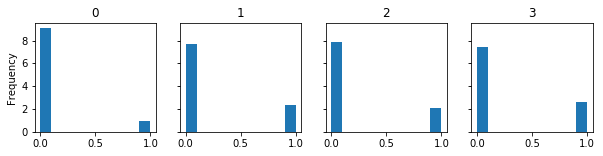

In [41]:
_, axes = pyplot.subplots(nrows=1, ncols=4, sharey='row', figsize=(10, 2))

for marriage in range(4):
    dataset[dataset['MARRIAGE'] == marriage]['default'].plot.hist(ax=axes[marriage], normed=True).set_title(marriage)
pyplot.show()

In [42]:
marriage_crosstab = pandas.crosstab(dataset['MARRIAGE'], dataset['default'])
marriage_crosstab

default,0,1
MARRIAGE,,
0,49,5
1,10453,3206
2,12623,3341
3,239,84



Вроде бы графики немного отличаются, но сходу непонятно, есть ли между признаками взаимосвязь.

Давайте проверим формально, связаны ли эти признаки (да-да, снова скажу, что критерий хи-квадрат для нулевой гипотезы о взаимной независимости этих величин против общей альтернативы):

In [43]:
chi2, p, dof, expected = stats.chi2_contingency(marriage_crosstab)
print('P-value: ',p)

('P-value: ', 8.825862457577375e-08)


Эти признаки действительно связаны, нулевая гипотеза отвергается на очень низком уровне. Давайте измерим взаимосвязь, а в качестве меры выберем коэффициент V Крамера:

In [50]:
def cramers_stat(observed) :
    """
    https://stackoverflow.com/a/38032115/359730
    """
    chi2,_,_,_ = stats.chi2_contingency(observed)
    n = observed.sum()
    return sqrt(chi2 / (float(n) * (min(observed.shape) - 1.)))


print('V: ',round(cramers_stat(marriage_crosstab.values),4))

('V: ', 0.0345)


Тоже хороший признак.

## Возраст (AGE)
Относительно двух групп людей вернувших и не вернувших кредит проверьте следующие гипотезы:

-о равенстве медианных значений возрастов людей

-о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. 


Значимы ли полученные результаты с практической точки зрения?

In [51]:
non_default_age = dataset[dataset['default'] == 0]['AGE']
default_age = dataset[dataset['default'] == 1]['AGE']

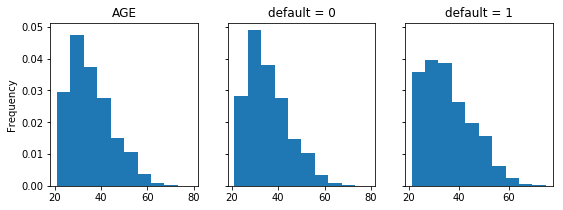

In [52]:
_, axes = pyplot.subplots(nrows=1, ncols=3, sharey='row', figsize=(9, 3))

dataset['AGE'].plot.hist(ax=axes[0], normed=True).set_title('AGE')
non_default_age.plot.hist(ax=axes[1], normed=True).set_title('default = 0')
default_age.plot.hist(ax=axes[2], normed=True).set_title('default = 1')
pyplot.show()

Вот здесь совсем не очевидно, есть ли разница между двумя группами по признаку default. Давайте проделаем те же проверки критериев.

Для начала бутстрап-критерий для проверки равенства математических ожиданий медиан.

In [53]:
numpy.random.seed(42)
n_samples = 100
non_default_age_medians = numpy.median(sample(non_default_age.values, n_samples), axis=1)
default_age_medians = numpy.median(sample(default_age.values, n_samples), axis=1)
statistics_intervals(default_age_medians - non_default_age_medians, 0.05)

array([0., 1.])